# Investigation of Wikipedia Recent Changes Summary Field

In [1]:
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
from scipy.stats import skew
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

## EDA

In [2]:
data = pd.read_json("../data/dump.json")

There are over 7,900 messages in the data dump.

In [3]:
data.shape

(7949, 19)

In [4]:
data.head()

,action,change_size,flags,geo_ip,hashtags,is_anon,is_bot,is_minor,is_new,is_unpatrolled,mentions,ns,page_title,parent_rev_id,rev_id,summary,timestamp,url,user
0,edit,377.0,None,NaN,[],False,False,False,False,False,[],Talk,Talk:Bajadasaurus,883357329.0,883356516.0,/* Images */,2019-02-14 22:43:57.810307,https://en.wikipedia.org/w/index.php?diff=8833...,FunkMonk
1,edit,-66.0,None,NaN,[],False,False,False,False,False,[],Main,The King of Fighters: Maximum Impact,883357327.0,883220913.0,None,2019-02-14 22:43:58.168588,https://en.wikipedia.org/w/index.php?diff=8833...,Benjaminkirsc
2,edit,-4635.0,B,NaN,[],False,True,False,False,False,[],User,User:AlexNewArtBot/WomensHistorySearchResult,883357322.0,883032645.0,"most recent results, added 113, removed 145, t...",2019-02-14 22:43:58.324169,https://en.wikipedia.org/w/index.php?diff=8833...,InceptionBot
3,edit,1.0,None,NaN,[],False,False,False,False,False,[],Template,Template:Samoa-party-stub,883357331.0,398617982.0,None,2019-02-14 22:43:58.613009,https://en.wikipedia.org/w/index.php?diff=8833...,HapHaxion
4,edit,37.0,None,NaN,[],False,False,False,False,False,[],Main,Persela Lamongan,883357330.0,883030131.0,None,2019-02-14 22:43:58.668958,https://en.wikipedia.org/w/index.php?diff=8833...,Afria Nuswantara


In [5]:
data.tail()

,action,change_size,flags,geo_ip,hashtags,is_anon,is_bot,is_minor,is_new,is_unpatrolled,mentions,ns,page_title,parent_rev_id,rev_id,summary,timestamp,url,user
7944,edit,-6.0,None,NaN,[],False,False,False,False,False,[],Template,Template:New Jersey State Senators,883364554.0,880713885.0,None,2019-02-14 23:43:53.182064,https://en.wikipedia.org/w/index.php?diff=8833...,Muboshgu
7945,edit,77.0,M,NaN,[],False,False,True,False,False,[],Main,Paulo Gazzaniga,883364555.0,882837596.0,None,2019-02-14 23:43:55.498175,https://en.wikipedia.org/w/index.php?diff=8833...,Car rush 1
7946,edit,30.0,N,NaN,[],False,False,False,True,False,[],Main,Inun-onan,NaN,883364557.0,[[WP:AES|←]]Redirected page to [[Paksiw#Inun-u...,2019-02-14 23:43:55.966439,https://en.wikipedia.org/w/index.php?oldid=883...,Obsidian Soul
7947,edit,-1.0,None,"{'city': 'Miami', 'country_name': 'United Stat...",[],True,False,False,False,False,[],Main,W. A. Martin,883364556.0,803817668.0,None,2019-02-14 23:43:56.318894,https://en.wikipedia.org/w/index.php?diff=8833...,2601:586:4104:6907:1E1:4F96:64E6:D917
7948,edit,7.0,MB,NaN,[],False,True,True,False,False,[],Main,Bruce Mayrock,883364558.0,878429616.0,Bot: Fixing double redirect to [[Nigerian Civi...,2019-02-14 23:43:57.136671,https://en.wikipedia.org/w/index.php?diff=8833...,EmausBot


The dataset was collected over an hour long period from approximately 22:43-23:43 14th February 2019.

In [6]:
print("Starting timestamp", data.timestamp.min())
print("Ending timestamp", data.timestamp.max())

Starting timestamp 2019-02-14 22:43:57.810307
Ending timestamp 2019-02-14 23:43:57.136671


The dataset contains messages relating to the English language site only, as far as can be determined.

In [7]:
data[data.url.str.contains("en.wikipedia.org") == True].shape

(7008, 19)

In [8]:
data[data.url.str.contains("en.wikipedia.org").isnull()].shape

(941, 19)

## Edits by User Category

For this report, only want to consider edits to main articles submitted by people rather than bots

In [9]:
main_articles = data[(data.ns == "Main") & (data.is_bot == False)]
main_articles.is_anon.value_counts()

False    3462
True     1007
Name: is_anon, dtype: int64

In [10]:
main_articles.summary.isnull().value_counts()

False    3577
True      892
Name: summary, dtype: int64

In [11]:
unregistered_users = main_articles[main_articles.is_anon == True]
registered_users = main_articles[main_articles.is_anon == False]

## Messages without Summary Field by User Category

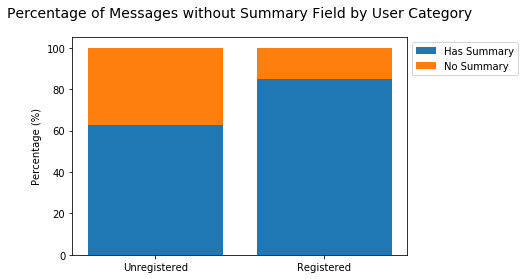

In [12]:
users_with_summary = [unregistered_users[~unregistered_users.summary.isnull()].shape[0], registered_users[~registered_users.summary.isnull()].shape[0]]
users_without_summary = [unregistered_users[unregistered_users.summary.isnull()].shape[0], registered_users[registered_users.summary.isnull()].shape[0]]

totals = [i+j for i,j in zip(users_with_summary,users_without_summary)]

with_summary = [i / j * 100 for i,j in zip(users_with_summary, totals)]
without_summary = [i / j * 100 for i,j in zip(users_without_summary, totals)]

xticks = [0,1]
plt.bar(xticks, with_summary)
plt.bar(xticks, without_summary, bottom=with_summary)
 
plt.title("Percentage of Messages without Summary Field by User Category", fontsize=14, pad=20)
plt.xticks(xticks, ["Unregistered","Registered"])
plt.ylabel("Percentage (%)")
plt.legend(["Has Summary", "No Summary"], bbox_to_anchor=(1, 1), loc="upper left")


plt.show()

## Top Verbs used in Summary Field by User Category

In [13]:
unregistered_users_with_summary = unregistered_users[~unregistered_users.summary.isnull()]
registered_users_with_summary = registered_users[~registered_users.summary.isnull()]

In [14]:
def parse_and_tokenize(summary):
    
    # parse summary, remove text contained in brackets and special symbols
    # this is assumed to be metadata
    summary = re.sub("[\(\[\/\{].*?[\}\/\)\]]", "", summary).strip()
    # simplify analysis by only extract alphabetic characters and standardise casing
    summary = " ".join(re.findall("[a-zA-Z]+", summary))
    summary = summary.lower()

    # get verbs only based on POS-tag
    is_verb = lambda pos: pos[:2] == "VB"
    tokenized = nltk.word_tokenize(summary)
    verbs = [word for (word, pos) in nltk.pos_tag(tokenized) if is_verb(pos)]
    
    return verbs
    

In [15]:
# this step is separate from the lemmatizer step to make it easier to link tokens to original messages if required
unregistered_users_with_summary["verbs"] = unregistered_users_with_summary.summary.apply(parse_and_tokenize)
registered_users_with_summary["verbs"] = registered_users_with_summary.summary.apply(parse_and_tokenize)

In [16]:
# pass this to TfidfVectorizer below
class Lemmatizer(object):
    
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def __call__(self, verbs):
        return [self.lemmatizer.lemmatize(verb, "v") for verb in verbs]

In [17]:
# a helper method to return sorted word tokens with corresponding IDFs
def get_verbs_idf(verbs):

    clf = TfidfVectorizer(tokenizer=Lemmatizer(), lowercase=False, stop_words=set(stopwords.words('english')))
    clf.fit(verbs)

    word2idf = dict(zip(clf.get_feature_names(), clf.idf_))
    return sorted(word2idf.items(), key=lambda x: x[1], reverse=False)

In [18]:
unregistered_users_sorted_idf = get_verbs_idf(unregistered_users_with_summary[unregistered_users_with_summary.verbs.str.len() != 0].verbs)
registered_users_sorted_idf = get_verbs_idf(registered_users_with_summary[registered_users_with_summary.verbs.str.len() != 0].verbs)

In [19]:
# total size of trained vocabularly for unregistered users
len(unregistered_users_sorted_idf)

94

In [20]:
# top 10 verbs by IDF
unregistered_users_sorted_idf[:10]

[('add', 2.3523928094442095),
 ('fix', 2.6933193964148026),
 ('remove', 3.163323025660538),
 ('correct', 3.6741486494265287),
 ('change', 3.9618307218783095),
 ('update', 3.9618307218783095),
 ('improve', 4.772760938094638),
 ('make', 4.772760938094638),
 ('miss', 4.772760938094638),
 ('edit', 5.060443010546419)]

In [21]:
# total size of trained vocabularly for registered users
len(registered_users_sorted_idf)

359

In [22]:
# top 10 verbs by IDF
registered_users_sorted_idf[:10]

[('add', 1.7867984561364523),
 ('revert', 3.1198379137207994),
 ('use', 3.152273189473953),
 ('fix', 3.9868320240837267),
 ('remove', 4.136772171374641),
 ('clean', 4.313228608716198),
 ('change', 4.922292672065602),
 ('create', 4.955082494888593),
 ('repair', 5.2207856606215985),
 ('surname', 5.2207856606215985)]

In [23]:
# separeted list of tuples into two lists
unregistered_users_verbs, unregistered_users_idfs = zip(*unregistered_users_sorted_idf)
unregistered_users_verbs = list(unregistered_users_verbs)
unregistered_users_idfs = list(unregistered_users_idfs)

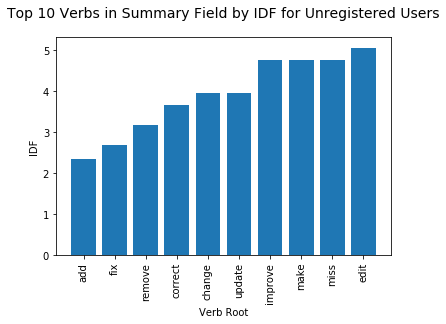

In [24]:
fig, ax = plt.subplots()

plt.bar(unregistered_users_verbs[:10], unregistered_users_idfs[:10])
plt.xticks(rotation='vertical')
plt.xlabel('Verb Root')
plt.ylabel('IDF')
plt.title('Top 10 Verbs in Summary Field by IDF for Unregistered Users', fontsize=14, pad=20)
plt.show()

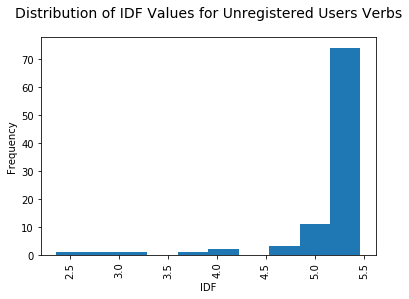

In [25]:
plt.hist(unregistered_users_idfs)
plt.xticks(rotation='vertical')
plt.xlabel('IDF')
plt.ylabel('Frequency')
plt.title('Distribution of IDF Values for Unregistered Users Verbs', fontsize=14, pad=20)
plt.show()

In [26]:
np.median(unregistered_users_idfs)

5.465908118654584

In [27]:
skew(unregistered_users_idfs)

-3.5318097708952405

In [28]:
# separeted list of tuples into two lists
registered_users_verbs, registered_users_idfs = zip(*registered_users_sorted_idf)
registered_users_verbs = list(registered_users_verbs)
registered_users_idfs = list(registered_users_idfs)

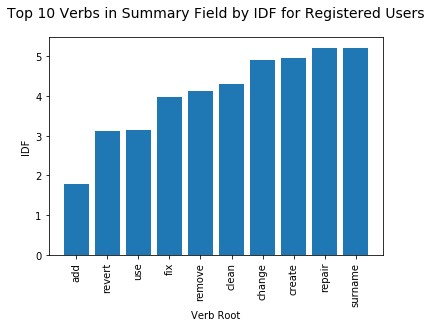

In [29]:
fig, ax = plt.subplots()

plt.bar(registered_users_verbs[:10], registered_users_idfs[:10])
plt.xticks(rotation='vertical')
plt.xlabel('Verb Root')
plt.ylabel('IDF')
plt.title('Top 10 Verbs in Summary Field by IDF for Registered Users', fontsize=14, pad=20)
plt.show()

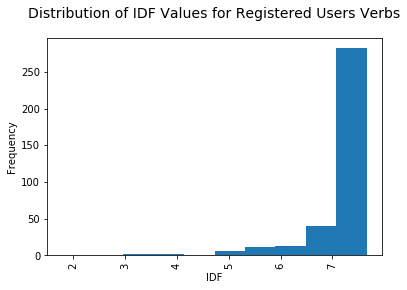

In [30]:
plt.hist(registered_users_idfs)
plt.xticks(rotation='vertical')
plt.xlabel('IDF')
plt.ylabel('Frequency')
plt.title('Distribution of IDF Values for Registered Users Verbs', fontsize=14, pad=20)
plt.show()

In [31]:
np.median(registered_users_idfs)

7.663132695990803

In [32]:
skew(registered_users_idfs)

-3.280953116278115

## Synonyms for Top Verbs by User Category

In [33]:
def get_word_synonyms(word, sent):
    word_synonyms = []
    for synset in wordnet.synsets(word):
        for lemma in synset.lemma_names():
            if lemma in sent and lemma != word:
                word_synonyms.append(lemma)
    
    if len(word_synonyms) == 0:
        return "No synonyms found"
    else:
        return ", ".join(sorted(set(word_synonyms)))

In [34]:
for verb in unregistered_users_verbs[:10]:
    print(verb)
    print(get_word_synonyms(verb, unregistered_users_verbs))
    print("-------------------------")

add
No synonyms found
-------------------------
fix
make, specify
-------------------------
remove
take, transfer
-------------------------
correct
adjust
-------------------------
change
transfer
-------------------------
update
No synonyms found
-------------------------
improve
amend
-------------------------
make
build, fix, form, take, work
-------------------------
miss
No synonyms found
-------------------------
edit
No synonyms found
-------------------------


In [35]:
for verb in registered_users_verbs[:10]:
    print(verb)
    print(get_word_synonyms(verb, registered_users_verbs))
    print("-------------------------")

add
No synonyms found
-------------------------
revert
return
-------------------------
use
No synonyms found
-------------------------
fix
define, get, jam, make, repair, restore, specify
-------------------------
remove
take
-------------------------
clean
blank
-------------------------
change
alter, convert, modify
-------------------------
create
make, produce
-------------------------
repair
fix, restore
-------------------------
surname
No synonyms found
-------------------------


## Unique Verbs by User Category

The following are lemmatised verbs used by unregistered users, not found in the set of registered user verbs.

In [36]:
unregistered_users_unique_verbs = np.setdiff1d(unregistered_users_verbs,registered_users_verbs)
unregistered_users_unique_verbs.size

51

In [37]:
unregistered_users_unique_verbs

array(['accompany', 'accord', 'account', 'acquire', 'allah', 'amend',
       'anyways', 'bore', 'build', 'byh', 'call', 'capitalize', 'career',
       'condemn', 'crew', 'cultivate', 'disestablish', 'doesnt',
       'external', 'feminine', 'ferry', 'forget', 'form', 'found',
       'frank', 'fred', 'gus', 'january', 'john', 'masculine', 'mcdonald',
       'medved', 'mil', 'ongoing', 'pixel', 'ppricem', 'prove', 'refer',
       'reflect', 'reopen', 'represent', 'require', 'reverse', 'separate',
       'serve', 'shoot', 'sympathetic', 'transfer', 'turn', 'wait',
       'worry'], dtype='<U12')

And the equivalent for registered user verbs.

In [38]:
registered_users_unique_verbs = np.setdiff1d(registered_users_verbs,unregistered_users_verbs)
registered_users_unique_verbs.size

316

In [39]:
registered_users_unique_verbs

array(['accept', 'accuse', 'afghanistan', 'ahmed', 'alexander', 'algebra',
       'alphabetize', 'alt', 'alter', 'alternative', 'announce', 'appear',
       'archive', 'article', 'assault', 'assert', 'assist', 'assume',
       'attend', 'attribute', 'avoid', 'b', 'balance', 'band', 'barbados',
       'base', 'become', 'begin', 'biography', 'blank', 'bowl', 'brave',
       'break', 'buy', 'c', 'caplitalized', 'caption', 'cast', 'cb', 'cc',
       'challenge', 'chart', 'check', 'clarify', 'cleae', 'clean', 'club',
       'colette', 'collaborate', 'columnised', 'combine', 'come', 'comey',
       'comhindipakistan', 'commit', 'compute', 'concert', 'confirm',
       'confuse', 'connect', 'consider', 'contain', 'continue',
       'contract', 'convert', 'count', 'create', 'credit', 'cut', 'dash',
       'date', 'decease', 'dedicate', 'define', 'delete', 'deorphaned',
       'describe', 'develop', 'dickens', 'die', 'discuss', 'e', 'ed',
       'edge', 'emfbroadcasting', 'end', 'endash', 'enjoy